
![alt text](https://pbs.twimg.com/media/DilKBjUVsAA74j1.jpg)

## Background Data

- Where there is salt, there is oil.
- But where is the salt?
- Classifying seismic imaging currently requires human (salt/not salt)
- Can we use an algorithm to do this instead? (yes)
- Seismic data is like an ultra-sound of the subsurface
- It uses wavelengths around 1m to 100m
- The Society of Exploration Geophysicists has 10K publications using the keyword 'salt'
- We can think of Earth as layered.
- Sand gets deposited on top of existing sand. And in comes the salt.
- There is an entire research branch dedicated to salt tectonics, that is the movement of salt in the subsurface.

## Our steps

- Install Dependencies
- Upload our Dataset
- View the labeled seismic imaging data
- Plot the depth distribution in the training data 
- Plot the proportion of salt vs depth in the training data
- Build a U-Net algorithm to learn the mapping between seismic images and the salt filter mask


In [49]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

from fastai.conv_learner import *


In [50]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [51]:
location = 'home'

if(location == 'home'):
    PATH = '/home/katou/Python/Data/Kaggle Salt Id/'
elif(location == 'work'):
    PATH = 'C:\\Users\\SCatheline\\Documents\\GitHub repo\\FirstTest\\Kaggle_Challenge_LIVE-master\\data\\'
else:
    print('Unavailable location.')
#train image + mask data
train_mask = pd.read_csv(PATH+'train.csv')
#depth data
depth = pd.read_csv(PATH+'depths.csv')
#training path
train_path = PATH+'train'

#list of files
file_list = list(train_mask['id'].values)
#define our dataset using our class
dataset = TGSSaltDataset(train_path, file_list)

In [52]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

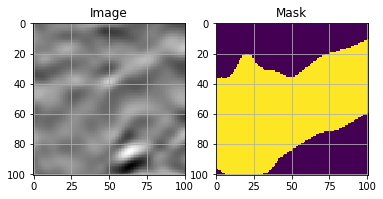

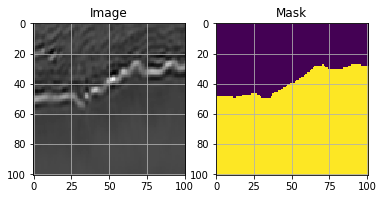

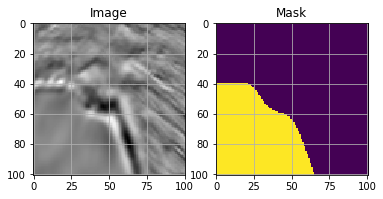

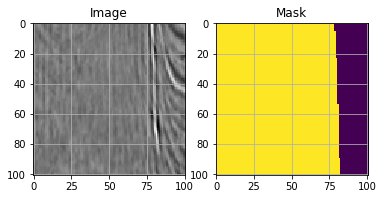

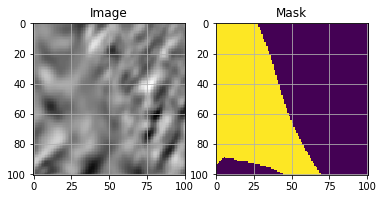

In [53]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

Text(0.5,1,'Depth distribution')

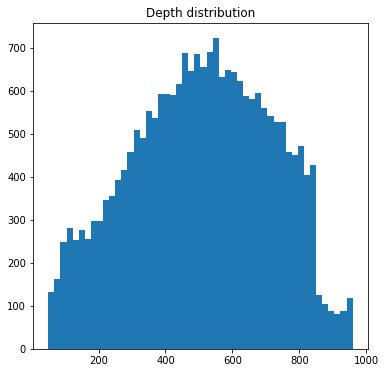

In [54]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

![alt text](https://sites.google.com/a/ruknuddin.com/inqilab-patel-magazine/_/rsrc/1525765922681/term-of-the-day/runlengthencoding/RunLengthEncoding.PNG)



In [55]:
#convert to image
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [56]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [57]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [58]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt v. depth')

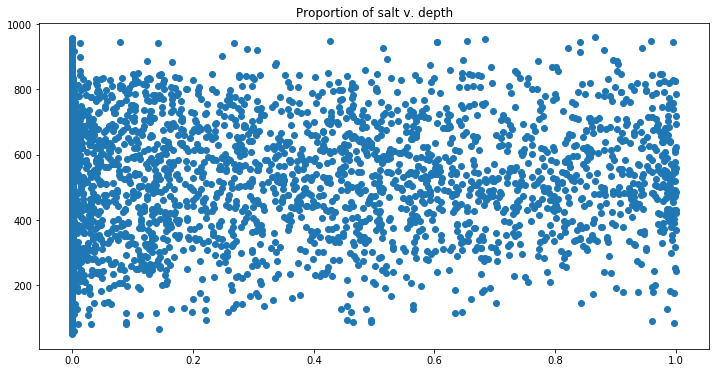

In [59]:
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')

In [60]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])


Correlation:  0.1036158036555743


#### U-Nets

- This looks like a computer vision problem!
- What outperforms everything else when it comes to computer vision most of the time? (hint deep learning)
- Specifically, deep convolutional neural networks.
- AlexNet
- VGG-16, VGG-19;
- Inception Nets;
- ResNet;
- Squeeze Net 

![alt text](https://pics.spark-in.me/upload/388373c74ab710cc4c429538d4779a93.png)
![alt text](https://pics.spark-in.me/upload/8b468c6dd60a499e6cdde0af803cb96f.png)

#### Why not use one of these, why use a U-Net?

- U-NET is considered one of standard architectures for image classification tasks, when we need not only to segment the whole image by its class, but also to segment areas of image by class, i.e. produce a mask that will separate image into several classes.
-its architecture is input image size agnostic since it does not contain fully connected layers 
- Because of many layers takes significant amount of time to train;
- U-Net is designed like an auto-encoder. 
- It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  
- However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. 
- For each pixel in the original image, it asks the question: “To which class does this pixel belong?
- This flexibility allows U-Net to predict different parts of the seismic image (salt, not salt) simultaneously.
- U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.  
- These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

#### What does a U-Net look like?

![alt text](https://cdn-images-1.medium.com/max/800/1*dKPBgCdJx6zj3MpED3lcNA.png)
![alt text](https://pics.spark-in.me/upload/cb8197bb7e57317eda88f921dfc1c413.png)

its high to low res, then low res to high res

- The first part (encoder) is where we apply convolutional blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.

convolutions→ downsampling.

Example

```
# a sample down block
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
self.down1 = nn.Sequential(
    *make_conv_bn_relu(in_channels, 64, kernel_size=3, stride=1, padding=1 ),
    *make_conv_bn_relu(64, 64, kernel_size=3, stride=1, padding=1 ),
)

# convolutions followed by a maxpool
down1 = self.down1(x)
out1   = F.max_pool2d(down1, kernel_size=2, stride=2)

```

- The  second part (decoder) of the network consists of upsample and concatenation followed by regular convolution operations

upsampling → concatenation →convolutions.

```
# a sample up block
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
self.up4 = nn.Sequential(
    *make_conv_bn_relu(128,64, kernel_size=3, stride=1, padding=1 ),
    *make_conv_bn_relu(64,64, kernel_size=3, stride=1, padding=1 )
)
self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

# upsample out_last, concatenate with down1 and apply conv operations
out   = F.upsample(out_last, scale_factor=2, mode='bilinear')  
out   = torch.cat([down1, out], 1)
out   = self.up4(out)

# final 1x1 conv for predictions
final_out = self.final_conv(out)
```




# CNN

In [61]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [62]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)
    
#learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)    

In [63]:
#model = ConvNet([3, 20, 40, 80], 10)

# Batchnorm

In [64]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)   #ni= in channels, nf = out channels
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

class UpLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)   #ni= in channels, nf = out channels
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)    

#learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)    
    
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)  
    
#learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)   

class UNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        #self.conv1 = nn.Conv2d(3, layers[0], kernel_size=3, stride=1, padding=2)
        self.num_neurons = layers[1]
        
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])

        layers2 = list(reversed(layers))
        
        self.layers3 = nn.ModuleList([nn.ConvTranspose2d(layers2[i], layers2[i+1],(2,2), stride = (2,2))
            for i in range(len(layers2) - 2)])    
        self.layers4 = nn.ModuleList([BnLayer(layers2[i+1], layers2[i+1], 1)
            for i in range(len(layers) - 2)])
        self.layers5 = nn.ModuleList([BnLayer(layers2[i+1], layers2[i+1], 1)
            for i in range(len(layers) - 2)])
        #self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        #x = self.conv1(x)
        ll = []
        #Down Pass
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
            ll.append(x)
            x = nn.MaxPool2d(3, stride=2)(x)
            x = nn.Dropout2d(p=0.5)(x)
        
        #Up Pass
        for l,l2,l3 in zip(self.layers3, self.layers4, self.layers5):
            #upsampling
            x = l(x)
            #concatenate
            x = torch.cat([x, ll.pop()], dim=-1)
            x = nn.Dropout2d(p=0.5)(x)
            #conv
            x = l2(x)
            x = l3(x)
            
        x =  F.sigmoid(nn.Conv2d(num_neurons, 1, kernel_size=(1,1), stride=1, bias=False, padding=0))
        return x  


# ResNET

In [65]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)
    
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)
    
#learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)    

# ResNet 2

In [66]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [67]:
bs = 32
im_width = 128
im_height = 128
sz = im_width
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth

In [68]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"/images"))[2] if location == 'home' else next(os.walk(train_path+"\\images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True) if location == 'home' else load_img(path + '\\images\\' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (sz, sz, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True)) if location == 'home' else img_to_array(load_img(path + '\\masks\\' + id_, grayscale=True))
    mask = resize(mask, (sz, sz, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]/home/katou/anaconda3/envs/GPU/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:13<00:00, 295.29it/s]

Done!


In [69]:
from sklearn.model_selection import train_test_split

#split the data using the coverage of salt in the image
Cov = np.zeros((y.shape[0],),dtype = float)
for i in range(y.shape[0]):
    Cov[i] = int(round(10*np.mean(y[i,:,:,0])))


X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, 
                                                                    test_size=0.15, stratify=Cov, random_state=42)


print(X_train.shape)
print(X_valid.shape)
print(X_feat_train.shape) 
print(X_feat_valid.shape )
print(y_train.shape )
print(y_valid.shape)


(3400, 128, 128, 2)
(600, 128, 128, 2)
(3400, 1)
(600, 1)
(3400, 128, 128, 1)
(600, 128, 128, 1)


Data Augmentation on the input
1) Images can be flipped vertically
2) Image can be tilted
3) Image can be dilated

!!!! NOTE that the augmentation can be added to the classification problem by predicting the class on augmented validation data. Here it should not be used because any transformation on the validation data will just mess up the pixel-wise classification 

In [70]:
PATH='./'
num_neurons = 16
#model = SimpleNet([sz*sz*2, 40,10])

#model = UNet([2,num_neurons, num_neurons*2, num_neurons*4, num_neurons*8, num_neurons*16])

In [71]:
model = ConvNet([2, 20, 40, 80], 10)

In [72]:
#tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
tfms = tfms_from_model(model, sz, aug_tfms=[transforms_top_down,transforms_side_on], max_zoom=1.1)

In [73]:
def ReshapeData(X):
    return X.reshape(X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])
print(X_train.shape)

X_train2 = ReshapeData(X_train)
y_train2 = ReshapeData(y_train)
X_valid2 = ReshapeData(X_valid)
y_valid2 = ReshapeData(y_valid)

(3400, 128, 128, 2)


In [74]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0




data = ImageClassifierData.from_arrays(PATH, (X_train2,y_train2),(X_valid2,y_valid2), tfms=tfms, bs=bs)
#ImageClassifierData.from_arrays(path, trn, val, bs=64, tfms=(None, None), classes=None, num_workers=4, 
                            #test=None, continuous=False)

In [79]:
ImageData??

In [76]:
learn = ConvLearner.from_model_data(model, data)  

In [80]:
ImageData.get_ds??

In [77]:
learn.summary()

RuntimeError: $ Torch: not enough memory: you tried to allocate 36GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/TH/THGeneral.cpp:204

In [42]:
lrf=learn.lr_find()

  0%|          | 0/107 [00:00<?, ?it/s]


TypeError: 'list' object is not callable

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(1e-2, 1)

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
print(results)
pred = model.predict({'img': X_valid, 'feat': X_feat_valid},verbose = 1)

print(pred.shape)
print(y_valid.shape)

In [ ]:
#from IOU_metric import iou_numpy
def iou_numpy(outputs: np.array, labels: np.array,threshold: float):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(axis = 3)
    labels = labels.squeeze(axis = 3)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    #thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    thresholded = np.ceil(np.clip(20 * (iou - threshold), 0, 10)) / 10
    
    return thresholded

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [ ]:
IOU2_50 = iou_metric_batch(np.round(y_valid).astype(int).squeeze(axis = 3),np.round(pred).astype(int).squeeze(axis = 3))
print('IOU metric: {0}'.format(np.mean(IOU2_50)))

In [ ]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(pred > threshold)) for threshold in thresholds])

In [ ]:
plt.plot(thresholds,ious,'-xb')

In [ ]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('Best IOU score: {0}, threshold used: {1}'.format(iou_best,threshold_best))

In [ ]:

a=pred.squeeze(axis = 3)
print(y_valid.shape)


In [ ]:
i=np.random.randint(0, y_valid.shape[0])

a= y_valid[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
b= pred[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
c = 255*X_valid[i,:,:,1].reshape((X_valid.shape[1],X_valid.shape[2]))

plot2x2Array(a, np.round(b))
plot2x2Array(a,c)

## Other model


In [ ]:
mod = 'standard_UNet'
class UnetKeras():
    def __init__(self, num_neurons, (im_height, im_width, im_chan), n_features):        
        # Build U-Net model
        input_img = Input((im_height, im_width, im_chan), name='img')
        input_features = Input((n_features, ), name='feat')

        c1 = Conv2D(num_neurons, (3, 3), activation='relu', padding='same') (input_img)
        c1 = Conv2D(num_neurons, (3, 3), activation='relu', padding='same') (c1)
        #c1 = BatchNormalization() (c1)              
        p1 = MaxPooling2D((2, 2)) (c1)
        p1 = Dropout(0.25) (p1)

        c2 = Conv2D(num_neurons*2, (3, 3), activation='relu', padding='same') (p1)
        c2 = Conv2D(num_neurons*2, (3, 3), activation='relu', padding='same') (c2)
        #c2 = BatchNormalization() (c2)                         
        p2 = MaxPooling2D((2, 2)) (c2)
        p2 = Dropout(0.5) (p2)

        c3 = Conv2D(num_neurons*4, (3, 3), activation='relu', padding='same') (p2)
        c3 = Conv2D(num_neurons*4, (3, 3), activation='relu', padding='same') (c3)
        #c3 = BatchNormalization() (c3)   
        p3 = MaxPooling2D((2, 2)) (c3)
        p3 = Dropout(0.5) (p3)

        c4 = Conv2D(num_neurons*8, (3, 3), activation='relu', padding='same') (p3)
        c4 = Conv2D(num_neurons*8, (3, 3), activation='relu', padding='same') (c4)
        #c4 = BatchNormalization() (c4)   
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
        p4 = Dropout(0.5) (p4)

        # Join features information in the depthest layer
        f_repeat = RepeatVector(8*8)(input_features)
        f_conv = Reshape((8, 8, n_features))(f_repeat)
        p4_feat = concatenate([p4, f_conv], -1)

        c5 = Conv2D(num_neurons*16, (3, 3), activation='relu', padding='same') (p4_feat)
        c5 = Conv2D(num_neurons*16, (3, 3), activation='relu', padding='same') (c5)

        u6 = Conv2DTranspose(num_neurons*8, (2, 2), strides=(2, 2), padding='same') (c5)
        #check out this skip connection thooooo
        u6 = concatenate([u6, c4])
        u6 = Dropout(0.5) (u6)
        c6 = Conv2D(num_neurons*8, (3, 3), activation='relu', padding='same') (u6)
        c6 = Conv2D(num_neurons*8, (3, 3), activation='relu', padding='same') (c6)

        u7 = Conv2DTranspose(num_neurons*4, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        u7 = Dropout(0.5) (u7)
        c7 = Conv2D(num_neurons*4, (3, 3), activation='relu', padding='same') (u7)
        c7 = Conv2D(num_neurons*4, (3, 3), activation='relu', padding='same') (c7)

        u8 = Conv2DTranspose(num_neurons*2, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        u8 = Dropout(0.5) (u8)
        c8 = Conv2D(num_neurons*2, (3, 3), activation='relu', padding='same') (u8)
        c8 = Conv2D(num_neurons*2, (3, 3), activation='relu', padding='same') (c8)

        u9 = Conv2DTranspose(num_neurons, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        u9 = Dropout(0.5) (u9)
        c9 = Conv2D(num_neurons, (3, 3), activation='relu', padding='same') (u9)
        c9 = Conv2D(num_neurons, (3, 3), activation='relu', padding='same') (c9)

        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[input_img, input_features], outputs=[outputs])
        return model

class Unet_Resnet():
    def BatchActivate(self,x):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def convolution_block(self,x, filters, size, strides=(1,1), padding='same', activation=True):
        x = Conv2D(filters, size, strides=strides, padding=padding)(x)
        if activation == True:
            x = BatchActivate(x)
        return x

    def residual_block(self,blockInput, num_filters=16, batch_activate = False):
        x = BatchActivate(blockInput)
        x = convolution_block(x, num_filters, (3,3) )
        x = convolution_block(x, num_filters, (3,3), activation=False)
        x = Add()([x, blockInput])
        if batch_activate:
            x = BatchActivate(x)
        return x
    def __init__(self,(im_height, im_width, im_chan),n_features)
        input_layer = Input((im_height, im_width, im_chan))
        input_features = Input((n_features, ), name='feat')

        DropoutRatio = 0.5
        start_neurons = 16
        # 101 -> 50
        conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
        conv1 = residual_block(conv1,start_neurons * 1)
        conv1 = residual_block(conv1,start_neurons * 1, True)
        pool1 = MaxPooling2D((2, 2))(conv1)
        pool1 = Dropout(DropoutRatio/2)(pool1)

        # 50 -> 25
        conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
        conv2 = residual_block(conv2,start_neurons * 2)
        conv2 = residual_block(conv2,start_neurons * 2, True)
        pool2 = MaxPooling2D((2, 2))(conv2)
        pool2 = Dropout(DropoutRatio)(pool2)

        # 25 -> 12
        conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
        conv3 = residual_block(conv3,start_neurons * 4)
        conv3 = residual_block(conv3,start_neurons * 4, True)
        pool3 = MaxPooling2D((2, 2))(conv3)
        pool3 = Dropout(DropoutRatio)(pool3)

        # 12 -> 6
        conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
        conv4 = residual_block(conv4,start_neurons * 8)
        conv4 = residual_block(conv4,start_neurons * 8, True)
        pool4 = MaxPooling2D((2, 2))(conv4)
        pool4 = Dropout(DropoutRatio)(pool4)

        # Join features information in the depthest layer
        f_repeat = RepeatVector(8*8)(input_features)
        f_conv = Reshape((8, 8, n_features))(f_repeat)
        pool4 = concatenate([pool4, f_conv], -1)

        # Middle
        convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
        convm = residual_block(convm,start_neurons * 16)
        convm = residual_block(convm,start_neurons * 16, True)

        # 6 -> 12
        deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
        uconv4 = concatenate([deconv4, conv4])
        uconv4 = Dropout(DropoutRatio)(uconv4)

        uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
        uconv4 = residual_block(uconv4,start_neurons * 8)
        uconv4 = residual_block(uconv4,start_neurons * 8, True)

        # 12 -> 25
        #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
        deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
        uconv3 = concatenate([deconv3, conv3])    
        uconv3 = Dropout(DropoutRatio)(uconv3)

        uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
        uconv3 = residual_block(uconv3,start_neurons * 4)
        uconv3 = residual_block(uconv3,start_neurons * 4, True)

        # 25 -> 50
        deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
        uconv2 = concatenate([deconv2, conv2])

        uconv2 = Dropout(DropoutRatio)(uconv2)
        uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
        uconv2 = residual_block(uconv2,start_neurons * 2)
        uconv2 = residual_block(uconv2,start_neurons * 2, True)

        # 50 -> 101
        #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
        deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
        uconv1 = concatenate([deconv1, conv1])

        uconv1 = Dropout(DropoutRatio)(uconv1)
        uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
        uconv1 = residual_block(uconv1,start_neurons * 1)
        uconv1 = residual_block(uconv1,start_neurons * 1, True)

        #uconv1 = Dropout(DropoutRatio/2)(uconv1)
        #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
        output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
        output_layer =  Activation('sigmoid')(output_layer_noActi)


        model = Model(inputs=[input_img, input_features], outputs=[outputs])

    
    #model = UnetKeras(num_neurons, (im_height, im_width, im_chan), n_features):
    #opt_adam = Adam(lr=0.001)
    #model.compile(optimizer=opt_adam, loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
    #model.summary()

In [ ]:
#callbacks = [
#    EarlyStopping(patience=10, verbose=1),
#    ReduceLROnPlateau(patience=3, verbose=1,min_lr=0.00001,factor=0.5),
#    ModelCheckpoint('model-tgs-salt-1-augmentation1_increased_dropout2_batchnorm2.h5', verbose=1, save_best_only=True, save_weights_only=True)
#]

#results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=100, verbose =1,callbacks=callbacks,
#                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid)
#                   )